# Handling Target-encoded Categoricals

In this notebook we'll go through the process of scanning a model with a dataset containing categorical fields which have been target encoded.  For the purposes of this example we use the `category_encoders` library, which will need to be installed in the pip/conda environment used when running this notebook.  Details may be found at http://contrib.scikit-learn.org/category_encoders/

In this example we will show:

* Handling of target-encoded categoricals in datasets and models provided to Certifai
* Handling of target-encoded protected groups for fairness analysis
* Bucketing of categoricals which are target-encoded
* Explanations provided in an unencoded space for easier user consumption (with multiple counterfactuals)
* Alternate fairness measures with target-encoded protected feature

In [1]:
import pandas as pd
import matplotlib as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from copy import copy

from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue,
                                      CertifaiFeatureRestriction, CertifaiGroupingBucket,
                                      CertifaiFeatureDataType, CertifaiFeatureSchema, CertifaiDataSchema)
from certifai.scanner.report_utils import scores, construct_scores_dataframe
from certifai.common.utils.encoding import CatEncoder
from certifai.scanner.explanation_utils import explanations, ExplainedPrediction
from certifai.engine.engine_api_types import ExplanationType

from category_encoders.target_encoder import TargetEncoder

## Dataset and ETL

We'll use the 'German Credit' dataset, and build a simple model to predict whether an individual's loan request will be granted of denied.

As an illustration we will target-encode some of the categorical fields that are present in this dataset.

In [2]:
# Example will use a simple logistic classifier on the German Credit dataset
base_path = '..'
all_data_file = f"{base_path}/datasets/german_credit_eval.csv"
encoded_data_file = "encoded_german_credit.csv"

original_df = pd.read_csv(all_data_file)

target_encoded_columns = [
    'checkingstatus',
    'status'
]

# Note - we omit the target encoded columns from the list of cat columns, since we're
# using this to drive one-hot encoding to the model of the remaining categoricals
cat_columns = [
    'history',
    'purpose',
    'savings',
    'employ',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

numeric = [c for c in original_df.columns if (c not in target_encoded_columns) and (c not in cat_columns)]

label_column = 'outcome'

# First perform the target encoding and then resave the dataset as a starting point for the
# actual analysis
df = original_df.copy()
target_encoder = TargetEncoder()
target_encoder.fit(df[target_encoded_columns], df[label_column])
df[target_encoded_columns] = target_encoder.transform(df[target_encoded_columns])
df.to_csv(encoded_data_file, index=False)

display(df)

,checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,...,property,age,otherplans,housing,cards,job,liable,telephone,foreign,outcome
0,1.222222,6,critical account/ other credits existing (not ...,car (new),1343,... < 100 DM,.. >= 7 years,1,1.266423,others - none,...,real estate,> 25 years,none,own,2,skilled employee / official,2,phone - none,foreign - no,1
1,1.492701,28,existing credits paid back duly till now,car (new),4006,... < 100 DM,1 <= ... < 4 years,3,1.266423,others - none,...,"car or other, not in attribute 6",> 25 years,none,own,1,unskilled - resident,1,phone - none,foreign - yes,2
2,1.116751,24,existing credits paid back duly till now,radio/television,2284,... < 100 DM,4 <= ... < 7 years,4,1.266423,others - none,...,"car or other, not in attribute 6",> 25 years,none,own,1,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes,1
3,1.116751,24,existing credits paid back duly till now,radio/television,1533,... < 100 DM,... < 1 year,4,1.351613,others - none,...,"car or other, not in attribute 6",> 25 years,stores,own,1,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes,1
4,1.116751,12,existing credits paid back duly till now,car (new),1101,... < 100 DM,1 <= ... < 4 years,3,1.271739,others - none,...,real estate,> 25 years,none,own,2,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.492701,18,all credits at this bank paid back duly,furniture/equipment,1553,... < 100 DM,1 <= ... < 4 years,4,1.266423,others - none,...,"car or other, not in attribute 6",> 25 years,bank,own,1,skilled employee / official,1,phone - none,foreign - yes,2
996,1.116751,24,critical account/ other credits existing (not ...,radio/television,1851,... < 100 DM,4 <= ... < 7 years,4,1.271739,guarantor,...,"car or other, not in attribute 6",> 25 years,none,own,2,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes,1
997,1.116751,36,existing credits paid back duly till now,furniture/equipment,3349,... < 100 DM,1 <= ... < 4 years,4,1.351613,others - none,...,"car or other, not in attribute 6",> 25 years,none,own,1,management/ self-employed/highly qualified emp...,1,"phone - yes, registered under the customers name",foreign - yes,2
998,1.222222,36,existing credits paid back duly till now,radio/television,4210,... < 100 DM,1 <= ... < 4 years,4,1.266423,others - none,...,"car or other, not in attribute 6",> 25 years,none,own,1,skilled employee / official,1,phone - none,foreign - yes,2


# Train Models

In [3]:
# Separate outcome
y = df[label_column]
X = df.drop(label_column, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Note - to support python multi-processing in the context of a notebook the encoder MUST
# be in a separate file, which is why `CatEncoder` is defined outside of this notebook
encoder = CatEncoder(cat_columns, X, numeric=numeric)

def build_model(data, name, model_family, test=None):
    if test is None:
        test = data
        
    if model_family == 'SVM':
        parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, .5, 1, 2, 4, 10], 'gamma':['auto']}
        m = svm.SVC()
    elif model_family == 'logistic':
        parameters = {'C': (0.5, 1.0, 2.0), 'solver': ['lbfgs'], 'max_iter': [1000]}
        m = LogisticRegression()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

svm_model = build_model((encoder(X_train.values), y_train),
                        'Support Vector Machine',
                        'SVM',
                        test=(encoder(X_test.values), y_test))

logistic_model = build_model((encoder(X_train.values), y_train),
                        'Logistic classifier',
                        'logistic',
                        test=(encoder(X_test.values), y_test))

Model 'Support Vector Machine' accuracy is 0.775
Model 'Logistic classifier' accuracy is 0.785


# Capture the target-encoding mappings

To have fully interpretable explanations and fairness results, we'll want to present them to the user in terms of the original (unencoded) field values.  To enable this we should tell Certifai what mappings were used.  Although this is optional, the results will have better readability with these provided.

Certifai can ingest these mappings in the form of a dictionary of dictionaries, wherein the top level is keyed on feature name, and the lower level dictionaries for each targe-encoded feature are a mapping of original feature values to encoded values.

We can generate this from the `TargetEncoder` instance we used to perform the original transformation.  In a real production setting one would either save off this mapping as part of the ETL process, or include the `TargetEncoder` (or equivalent if using some other encoding software) along with the model to make it available later.

In [4]:
target_mappings = {}
for feature in target_encoded_columns:
    feature_mappings = {}
    for ordinal_mapping in target_encoder.ordinal_encoder.category_mapping:
        if ordinal_mapping['col'] == feature:
            mapping = ordinal_mapping['mapping']
            for idx, ordinal in enumerate(mapping):
                label = mapping.index[idx]
                if not (isinstance(label, float) and np.isnan(label)):
                    feature_mappings[label] = target_encoder.mapping[feature][ordinal]
            break
    target_mappings[feature] = feature_mappings

## Analyze for fairness

Now we'll perform a Certifai scan to analyze our models for bias with respect to status (which is one of our target-encoded fields)

In [5]:
# Wrap the model up for use by Certifai as a local model
svm_model_proxy = CertifaiPredictorWrapper(svm_model, encoder=encoder)
logistic_model_proxy = CertifaiPredictorWrapper(logistic_model, encoder=encoder)

In [6]:
# Create the scan object from scratch using the ScanBuilder class

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

scan = CertifaiScanBuilder.create('test_use_case',
                                  prediction_task=task)

# Add our local models
first_model = CertifaiModel('SVM',
                            local_predictor=svm_model_proxy)
scan.add_model(first_model)
second_model = CertifaiModel('logistic',
                            local_predictor=logistic_model_proxy)
scan.add_model(second_model)

# Add the eval dataset
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.csv(encoded_data_file))
scan.add_dataset(eval_dataset)

# Add the explanation dataset - we're only going to bother extracting a small number here
expl_dataset = CertifaiDataset('explanation',
                               CertifaiDatasetSource.dataframe(df[:10]))
scan.add_dataset(expl_dataset)

# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity between groups defined by status, and group it into
# two buckets (male and female) to get at gender bias
female_statuses = [s for s in original_df['status'].unique() if 'female' in s]
male_statuses = [s for s in original_df['status'].unique() if 'female' not in s]
status_grouping = CertifaiGroupingFeature('status',
                                       buckets=[
                                           CertifaiGroupingBucket('female', values=female_statuses),
                                           CertifaiGroupingBucket('male', values=male_statuses)
                                       ])
scan.add_fairness_grouping_feature(status_grouping)

# Let's look at an additional fairness metric along with counterfactual fairness
scan.add_fairness_metric('demographic parity')

scan.add_evaluation_type('explanation')
scan.add_evaluation_type('fairness')
scan.evaluation_dataset_id = 'evaluation'
scan.explanation_dataset_id = 'explanation'
scan.hyper_parameter_overrides = {
    'num_counterfactuals': 4
}

# Because some fields are target-encoded we need to define them in the schema so that
# Certifai knows the value mappings
schema = CertifaiDataSchema()
for feature, value_mappings in target_mappings.items():
    values = []
    encodings = []
    for value, encoding in value_mappings.items():
        values.append(value)
        encodings.append(encoding)
    schema.add_feature(name=feature, data_type=CertifaiFeatureDataType.categorical(values=values,
                                                                                   target_encodings=encodings))
scan.dataset_schema = schema

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
scan.dataset_schema.outcome_feature_name = label_column

# Run the scan.
result = scan.run(write_reports=False)


Starting scan with model_use_case_id: 'test_use_case' and scan_id: 'e52ecadfc60a'
[--------------------] 2023-01-05 12:07:59.312538 - 0 of 6 reports (0.0% complete) - Running explanation evaluation for model: SVM
[###-----------------] 2023-01-05 12:08:18.865082 - 1 of 6 reports (16.67% complete) - Running fairness evaluation for model: SVM


2023-01-05 12:10:56,556 root   WARNING  Examples of protected class ('status', 'female') exhausted before convergence after 310 samples
2023-01-05 12:11:54,518 root   WARNING  Examples of protected class ('status', 'male') exhausted before convergence after 690 samples


[######--------------] 2023-01-05 12:12:12.303079 - 2 of 6 reports (33.33% complete) - Running atx evaluation for model: SVM
[##########----------] 2023-01-05 12:12:12.304854 - 3 of 6 reports (50.0% complete) - Running explanation evaluation for model: logistic
[#############-------] 2023-01-05 12:12:19.194352 - 4 of 6 reports (66.67% complete) - Running fairness evaluation for model: logistic


2023-01-05 12:13:33,426 root   WARNING  Examples of protected class ('status', 'female') exhausted before convergence after 310 samples
2023-01-05 12:14:04,319 root   WARNING  Examples of protected class ('status', 'male') exhausted before convergence after 690 samples


[################----] 2023-01-05 12:14:22.431516 - 5 of 6 reports (83.33% complete) - Running atx evaluation for model: logistic
[####################] 2023-01-05 12:14:22.433395 - 6 of 6 reports (100.0% complete) - Completed all evaluations


In [7]:
# The result is a dictionary keyed on analysis, containing reports keyed on model id
# The console app is the recommended way to view these, by saving the results to file
# (see previous cell), but programmatic analysis of the result here is also possible
df = construct_scores_dataframe(scores('fairness', result), include_confidence=True)
display(df)

,context,type,fairness,Feature (status),Feature (status) lower bound,Feature (status) upper bound,type in Feature (status),Group details (female),Group details (female) lower bound,Group details (female) upper bound,type in Feature (status),Group details (male),Group details (male) lower bound,Group details (male) upper bound
SVM (burden),SVM,burden,86.659100,86.659100,73.974635,98.176668,burden,0.045475,0.036555,0.054959,burden,0.034689,0.028986,0.040336
SVM (demographic parity),SVM,demographic parity,93.151894,93.151894,87.918060,98.397008,positive prediction rate,0.784946,0.745098,0.822006,positive prediction rate,0.843023,0.819225,0.864748
logistic (burden),logistic,burden,81.585489,81.585489,71.470326,91.612311,burden,0.060637,0.051726,0.070997,burden,0.041989,0.035958,0.047344
logistic (demographic parity),logistic,demographic parity,88.781174,88.781174,82.928545,95.195549,positive prediction rate,0.707395,0.663430,0.750769,positive prediction rate,0.796348,0.770370,0.820961


,context,type,fairness,Feature (status),Feature (status) lower bound,Feature (status) upper bound,type in Feature (status),Group details (female),Group details (female) lower bound,Group details (female) upper bound,type in Feature (status),Group details (male),Group details (male) lower bound,Group details (male) upper bound
SVM (burden),SVM,burden,86.659100,86.659100,73.974635,98.176668,burden,0.045475,0.036555,0.054959,burden,0.034689,0.028986,0.040336
SVM (demographic parity),SVM,demographic parity,93.151894,93.151894,87.918060,98.397008,positive prediction rate,0.784946,0.745098,0.822006,positive prediction rate,0.843023,0.819225,0.864748
logistic (burden),logistic,burden,81.585489,81.585489,71.470326,91.612311,burden,0.060637,0.051726,0.070997,burden,0.041989,0.035958,0.047344
logistic (demographic parity),logistic,demographic parity,88.781174,88.781174,82.928545,95.195549,positive prediction rate,0.707395,0.663430,0.750769,positive prediction rate,0.796348,0.770370,0.820961


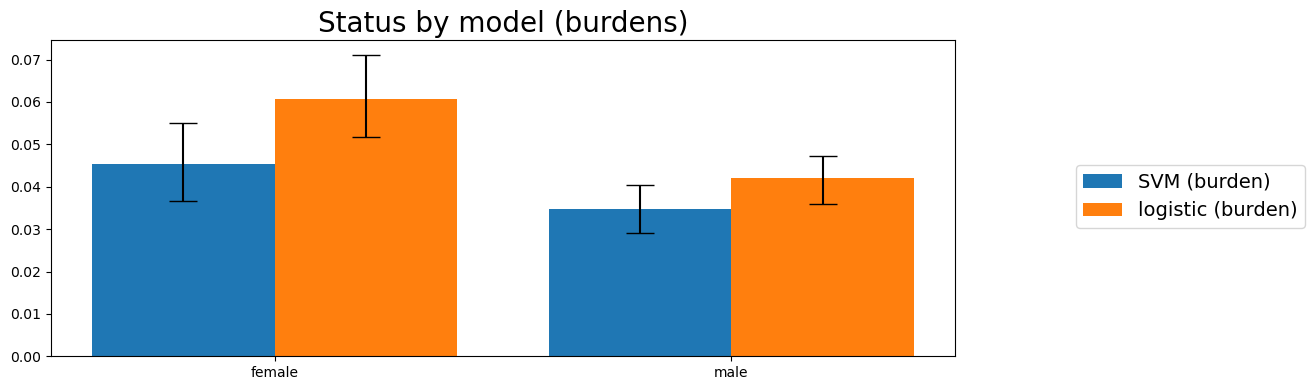

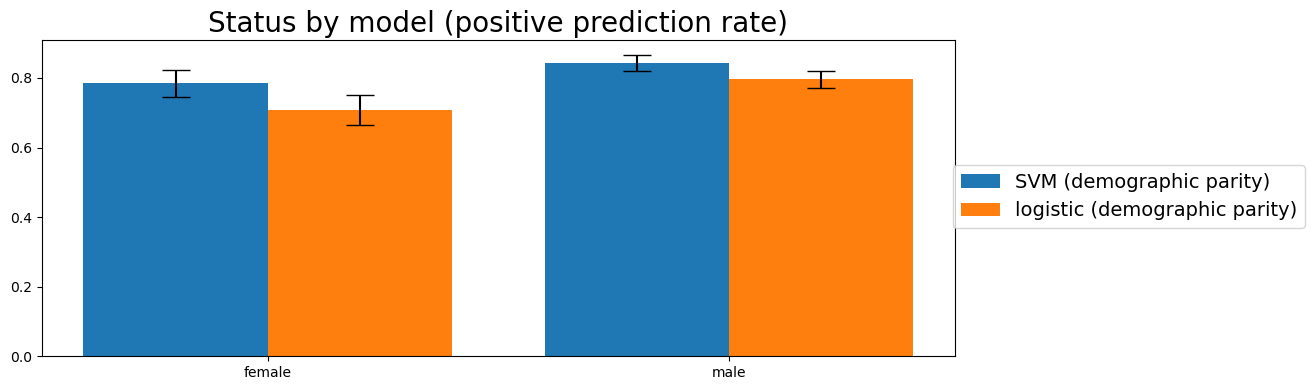

In [8]:
# Many scores also come with 95% confidence bounds, which we omitted above for the sake of brevity, but
# we can include those also.  In the example here we include the confidence bounds but only display the scores
# to a reduced level of detail to keep a smallish table for display purposes
df = construct_scores_dataframe(scores('fairness', result, max_depth=1))

display(df)

print("\n")

# Let's chart the fairness measure by status for each model together with its confidence bounds for
# easier visual comparison:
%matplotlib inline
import matplotlib.pyplot as plt

groups = [
    'female : divorced/separated/married',
    'male : divorced/separated',
    'male : married/widowed',
    'male : single'
]
groups = [
    'female',
    'male'
]

def display_chart(rows, units):
    feature_scores = rows[[f"Group details ({g})" for g in groups]]
    feature_lower_bounds = rows[[f + ' lower bound' for f in feature_scores]]
    feature_upper_bounds = rows[[f + ' upper bound' for f in feature_scores]]

    fig, ax = plt.subplots(figsize=[12,4])
    ax.set_title(f'Status by model ({units})', fontsize=20)
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
    width = 0.4

    ax.set_xticks(np.arange(len(groups))+width)
    ax.set_xticklabels(groups)

    for idx in range(len(rows)):
        central_values = list(feature_scores.iloc[idx])
        lower_bounds = list(feature_lower_bounds.iloc[idx])
        upper_bounds = list(feature_upper_bounds.iloc[idx])
        lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
        upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

        ax.bar([width/2+idx*width+f_idx for f_idx in range(len(groups))],
                central_values,
                width,
                yerr=[lower_errors, upper_errors],
                color=colors[idx],
                label=rows.index[idx],
                capsize=10)

    fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
    fig.tight_layout()
    fig.subplots_adjust(right=0.8) 
    plt.show()

display_chart(df.loc[['SVM (burden)', 'logistic (burden)']], 'burdens')
display_chart(df.loc[['SVM (demographic parity)', 'logistic (demographic parity)']], 'positive prediction rate')

## Conclusion

As we can see from the above chart, it's more difficult for females to get access to loans than for males. This tendency is more pronounced with the logistic classifier than with the SVM.

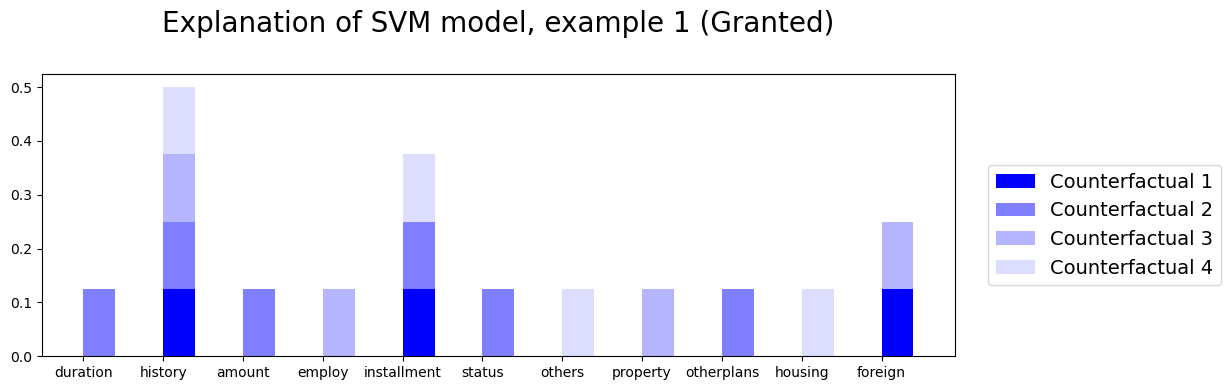

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... >= 200 DM / salary assignments for at least 1 year,6,critical account/ other credits existing (not at this bank),car (new),1343,... < 100 DM,.. >= 7 years,1,male : single,others - none,4,real estate,> 25 years,none,own,2,skilled employee / official,2,phone - none,foreign - no


,duration,history,amount,employ,installment,status,others,property,otherplans,housing,foreign
Original,6,critical account/ other credits existing (not ...,1343,.. >= 7 years,1,male : single,others - none,real estate,none,own,foreign - no
Counterfactual 1,6,all credits at this bank paid back duly,1343,.. >= 7 years,4,male : single,others - none,real estate,none,own,foreign - yes
Counterfactual 2,10,all credits at this bank paid back duly,1266,.. >= 7 years,4,male : married/widowed,others - none,real estate,bank,own,foreign - no
Counterfactual 3,6,all credits at this bank paid back duly,1343,... < 1 year,1,male : single,others - none,unknown / no property,none,own,foreign - yes
Counterfactual 4,6,all credits at this bank paid back duly,1343,.. >= 7 years,4,male : single,co-applicant,real estate,none,rent,foreign - no


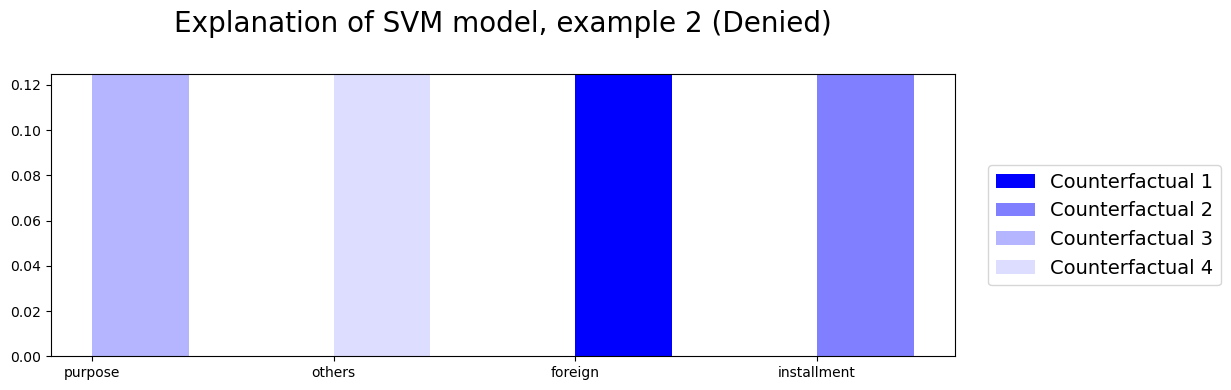

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... < 0 DM,28,existing credits paid back duly till now,car (new),4006,... < 100 DM,1 <= ... < 4 years,3,male : single,others - none,2,"car or other, not in attribute 6",> 25 years,none,own,1,unskilled - resident,1,phone - none,foreign - yes


,purpose,others,foreign,installment
Original,car (new),others - none,foreign - yes,3
Counterfactual 1,car (new),others - none,foreign - no,3
Counterfactual 2,car (new),others - none,foreign - yes,1
Counterfactual 3,radio/television,others - none,foreign - yes,3
Counterfactual 4,car (new),guarantor,foreign - yes,3


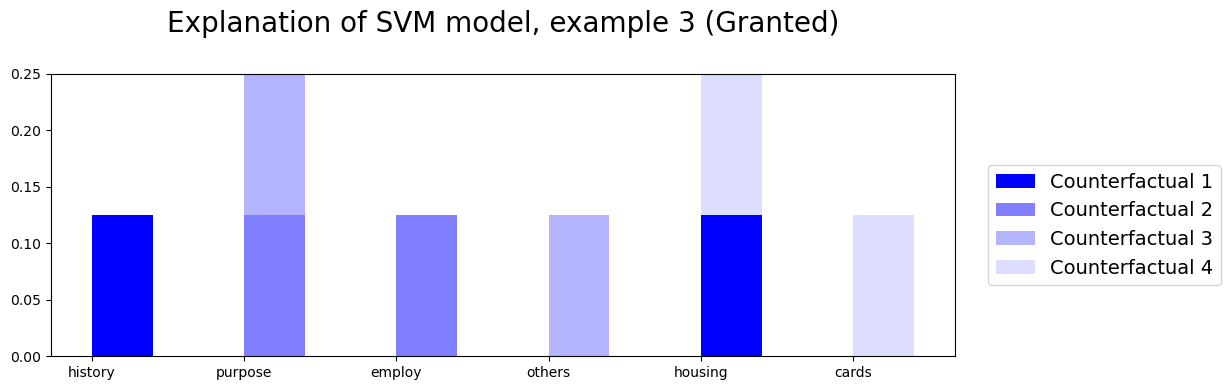

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,24,existing credits paid back duly till now,radio/television,2284,... < 100 DM,4 <= ... < 7 years,4,male : single,others - none,2,"car or other, not in attribute 6",> 25 years,none,own,1,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,history,purpose,employ,others,housing,cards
Original,existing credits paid back duly till now,radio/television,4 <= ... < 7 years,others - none,own,1
Counterfactual 1,all credits at this bank paid back duly,radio/television,4 <= ... < 7 years,others - none,rent,1
Counterfactual 2,existing credits paid back duly till now,education,... < 1 year,others - none,own,1
Counterfactual 3,existing credits paid back duly till now,education,4 <= ... < 7 years,co-applicant,own,1
Counterfactual 4,existing credits paid back duly till now,radio/television,4 <= ... < 7 years,others - none,rent,4


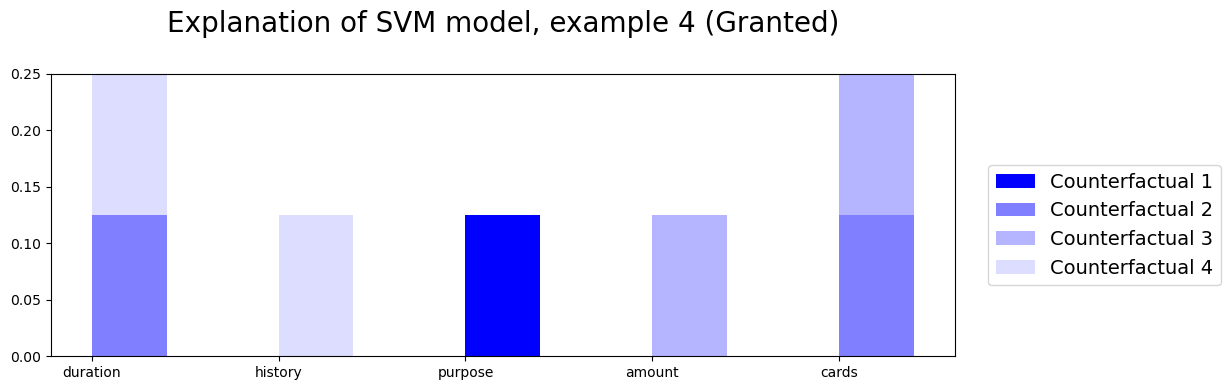

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,24,existing credits paid back duly till now,radio/television,1533,... < 100 DM,... < 1 year,4,female : divorced/separated/married,others - none,3,"car or other, not in attribute 6",> 25 years,stores,own,1,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,duration,history,purpose,amount,cards
Original,24,existing credits paid back duly till now,radio/television,1533,1
Counterfactual 1,24,existing credits paid back duly till now,education,1533,1
Counterfactual 2,25,existing credits paid back duly till now,radio/television,1533,4
Counterfactual 3,24,existing credits paid back duly till now,radio/television,1778,4
Counterfactual 4,26,all credits at this bank paid back duly,radio/television,1533,1


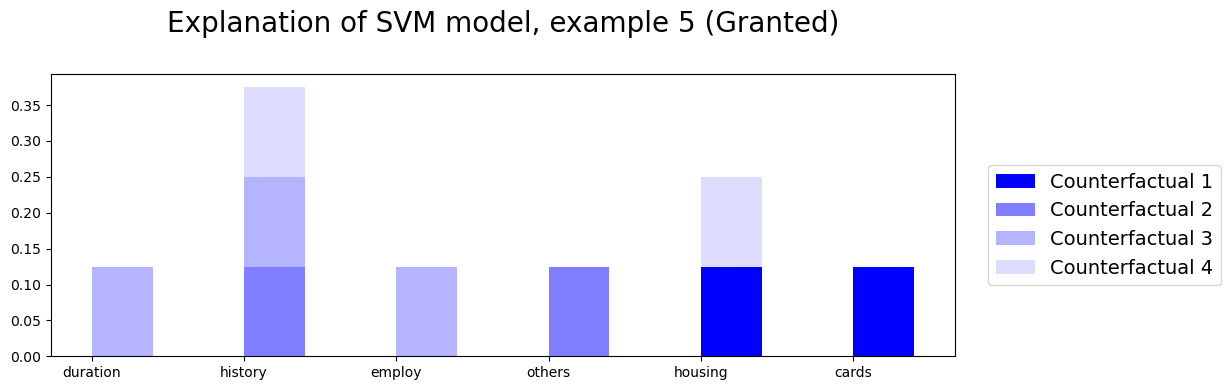

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,12,existing credits paid back duly till now,car (new),1101,... < 100 DM,1 <= ... < 4 years,3,male : married/widowed,others - none,2,real estate,> 25 years,none,own,2,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,duration,history,employ,others,housing,cards
Original,12,existing credits paid back duly till now,1 <= ... < 4 years,others - none,own,2
Counterfactual 1,12,existing credits paid back duly till now,1 <= ... < 4 years,others - none,rent,4
Counterfactual 2,12,all credits at this bank paid back duly,1 <= ... < 4 years,co-applicant,own,2
Counterfactual 3,13,all credits at this bank paid back duly,... < 1 year,others - none,own,2
Counterfactual 4,12,all credits at this bank paid back duly,1 <= ... < 4 years,others - none,rent,2


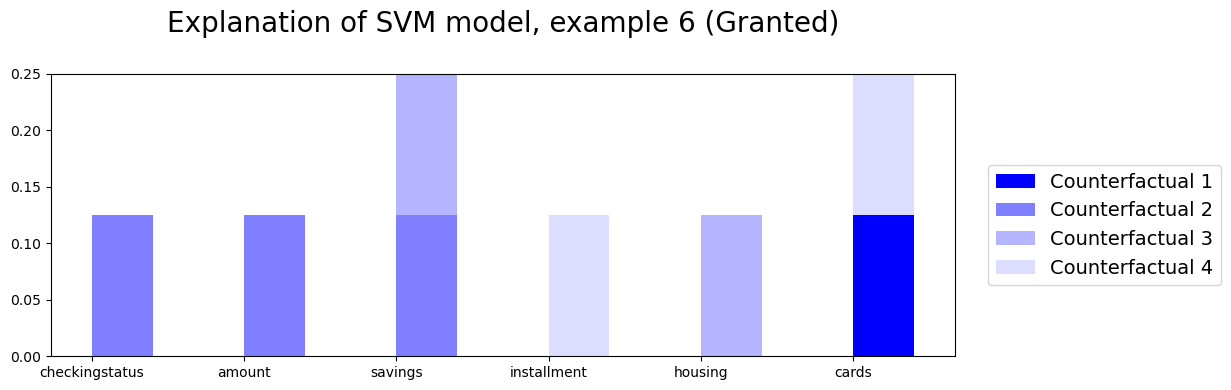

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,60,critical account/ other credits existing (not at this bank),car (new),13756,unknown/ no savings account,.. >= 7 years,2,male : single,others - none,4,unknown / no property,> 25 years,bank,for free,1,management/ self-employed/highly qualified employee/ officer,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,amount,savings,installment,housing,cards
Original,no checking account,13756,unknown/ no savings account,2,for free,1
Counterfactual 1,no checking account,13756,unknown/ no savings account,2,for free,4
Counterfactual 2,... >= 200 DM / salary assignments for at leas...,13798,... < 100 DM,2,for free,1
Counterfactual 3,no checking account,13756,... < 100 DM,2,own,1
Counterfactual 4,no checking account,13756,unknown/ no savings account,4,for free,3


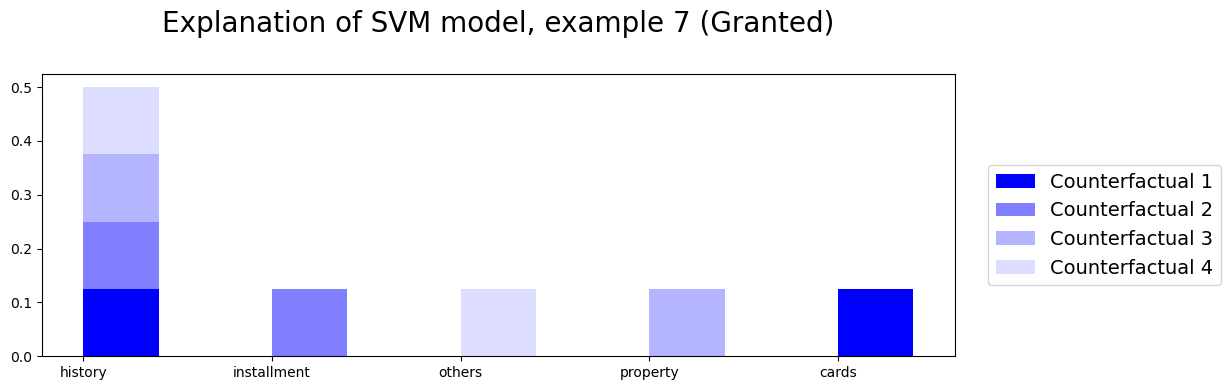

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... < 0 DM,6,critical account/ other credits existing (not at this bank),car (new),4716,unknown/ no savings account,... < 1 year,1,male : single,others - none,3,real estate,> 25 years,none,own,2,unskilled - resident,2,phone - none,foreign - yes


,history,installment,others,property,cards
Original,critical account/ other credits existing (not ...,1,others - none,real estate,2
Counterfactual 1,all credits at this bank paid back duly,1,others - none,real estate,4
Counterfactual 2,all credits at this bank paid back duly,4,others - none,real estate,2
Counterfactual 3,all credits at this bank paid back duly,1,others - none,unknown / no property,2
Counterfactual 4,all credits at this bank paid back duly,1,co-applicant,real estate,2


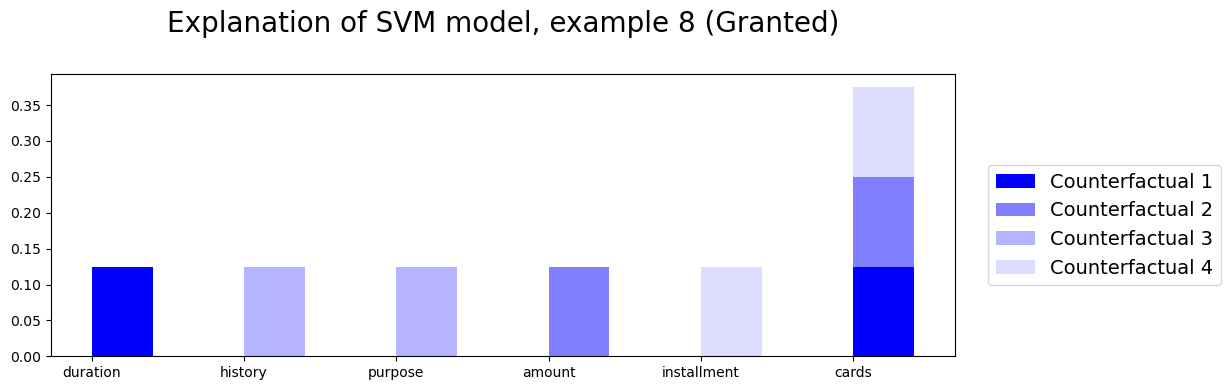

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... >= 200 DM / salary assignments for at least 1 year,12,existing credits paid back duly till now,radio/television,1881,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,others - none,2,"car or other, not in attribute 6",> 25 years,none,rent,1,unskilled - resident,1,"phone - yes, registered under the customers name",foreign - yes


,duration,history,purpose,amount,installment,cards
Original,12,existing credits paid back duly till now,radio/television,1881,2,1
Counterfactual 1,13,existing credits paid back duly till now,radio/television,1881,2,4
Counterfactual 2,12,existing credits paid back duly till now,radio/television,2405,2,4
Counterfactual 3,12,all credits at this bank paid back duly,car (new),1881,2,1
Counterfactual 4,12,existing credits paid back duly till now,radio/television,1881,3,4


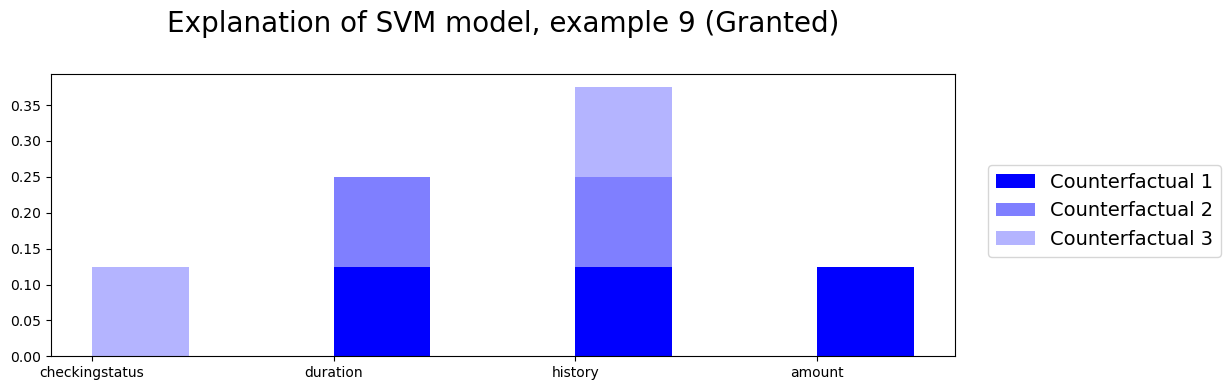

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,24,delay in paying off in the past,car (new),2032,... < 100 DM,.. >= 7 years,4,male : single,others - none,4,unknown / no property,> 25 years,none,for free,2,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,duration,history,amount
Original,no checking account,24,delay in paying off in the past,2032
Counterfactual 1,no checking account,26,all credits at this bank paid back duly,2211
Counterfactual 2,no checking account,27,all credits at this bank paid back duly,2032
Counterfactual 3,... >= 200 DM / salary assignments for at leas...,24,all credits at this bank paid back duly,2032


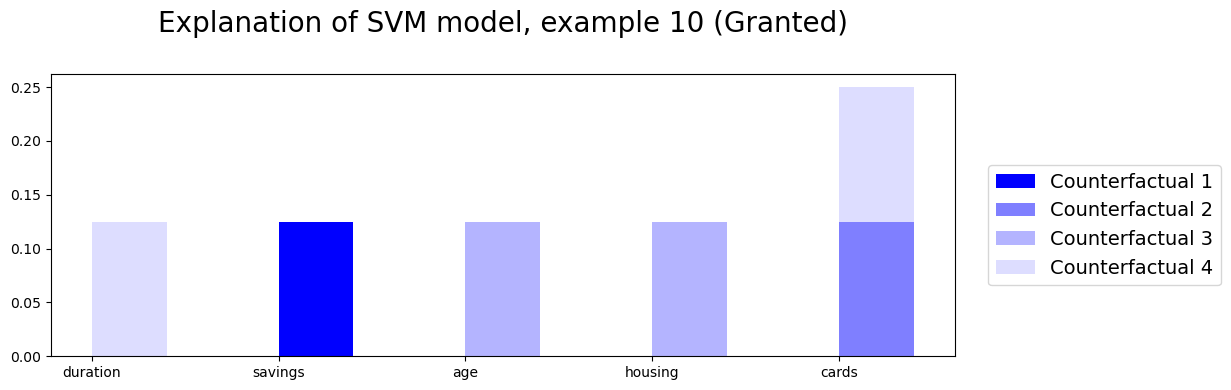

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,36,existing credits paid back duly till now,car (new),3079,unknown/ no savings account,1 <= ... < 4 years,4,male : single,others - none,4,real estate,> 25 years,none,own,1,skilled employee / official,1,phone - none,foreign - yes


,duration,savings,age,housing,cards
Original,36,unknown/ no savings account,> 25 years,own,1
Counterfactual 1,36,... < 100 DM,> 25 years,own,1
Counterfactual 2,36,unknown/ no savings account,> 25 years,own,4
Counterfactual 3,36,unknown/ no savings account,<= 25 years,rent,1
Counterfactual 4,40,unknown/ no savings account,> 25 years,own,3


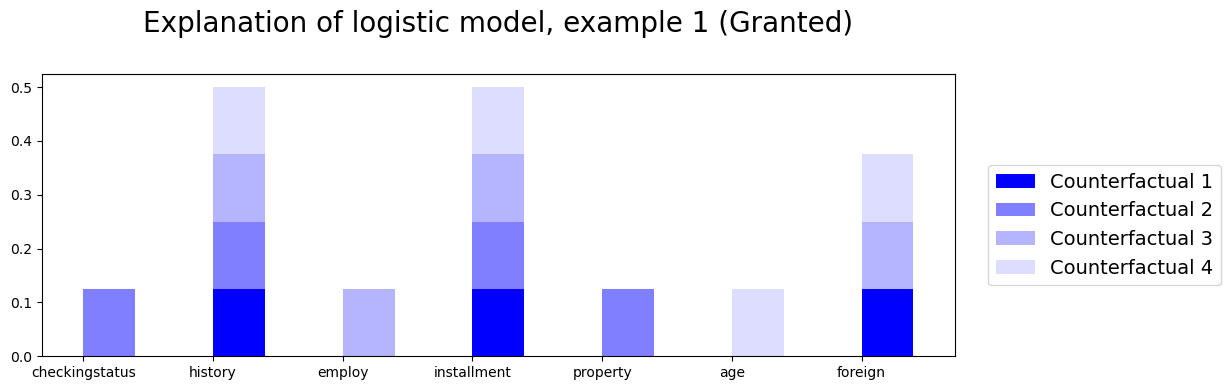

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... >= 200 DM / salary assignments for at least 1 year,6,critical account/ other credits existing (not at this bank),car (new),1343,... < 100 DM,.. >= 7 years,1,male : single,others - none,4,real estate,> 25 years,none,own,2,skilled employee / official,2,phone - none,foreign - no


,checkingstatus,history,employ,installment,property,age,foreign
Original,... >= 200 DM / salary assignments for at leas...,critical account/ other credits existing (not ...,.. >= 7 years,1,real estate,> 25 years,foreign - no
Counterfactual 1,... >= 200 DM / salary assignments for at leas...,all credits at this bank paid back duly,.. >= 7 years,4,real estate,> 25 years,foreign - yes
Counterfactual 2,0 <= ... < 200 DM,all credits at this bank paid back duly,.. >= 7 years,4,unknown / no property,> 25 years,foreign - no
Counterfactual 3,... >= 200 DM / salary assignments for at leas...,no credits taken/ all credits paid back duly,... < 1 year,4,real estate,> 25 years,foreign - yes
Counterfactual 4,... >= 200 DM / salary assignments for at leas...,no credits taken/ all credits paid back duly,.. >= 7 years,4,real estate,<= 25 years,foreign - yes


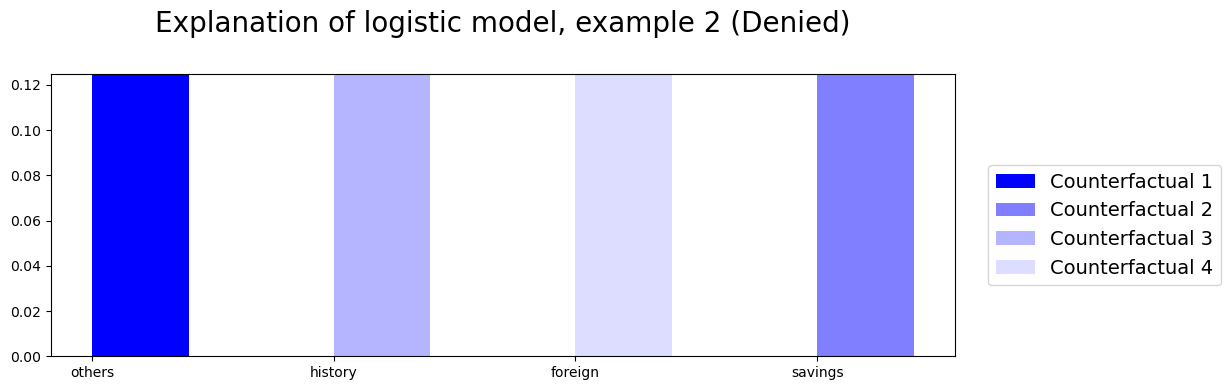

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... < 0 DM,28,existing credits paid back duly till now,car (new),4006,... < 100 DM,1 <= ... < 4 years,3,male : single,others - none,2,"car or other, not in attribute 6",> 25 years,none,own,1,unskilled - resident,1,phone - none,foreign - yes


,others,history,foreign,savings
Original,others - none,existing credits paid back duly till now,foreign - yes,... < 100 DM
Counterfactual 1,guarantor,existing credits paid back duly till now,foreign - yes,... < 100 DM
Counterfactual 2,others - none,existing credits paid back duly till now,foreign - yes,.. >= 1000 DM
Counterfactual 3,others - none,critical account/ other credits existing (not ...,foreign - yes,... < 100 DM
Counterfactual 4,others - none,existing credits paid back duly till now,foreign - no,... < 100 DM


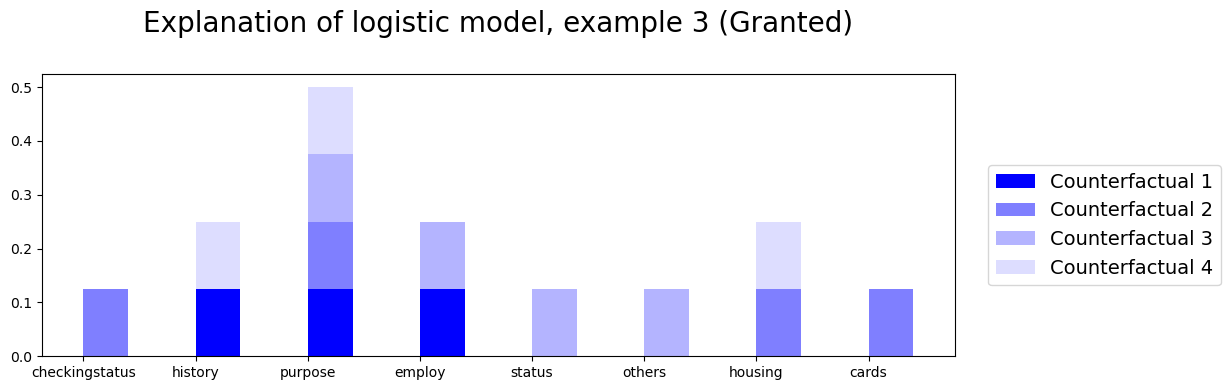

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,24,existing credits paid back duly till now,radio/television,2284,... < 100 DM,4 <= ... < 7 years,4,male : single,others - none,2,"car or other, not in attribute 6",> 25 years,none,own,1,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,history,purpose,employ,status,others,housing,cards
Original,no checking account,existing credits paid back duly till now,radio/television,4 <= ... < 7 years,male : single,others - none,own,1
Counterfactual 1,no checking account,all credits at this bank paid back duly,education,... < 1 year,male : single,others - none,own,1
Counterfactual 2,... >= 200 DM / salary assignments for at leas...,existing credits paid back duly till now,car (new),4 <= ... < 7 years,male : single,others - none,rent,4
Counterfactual 3,no checking account,existing credits paid back duly till now,car (new),... < 1 year,male : married/widowed,co-applicant,own,1
Counterfactual 4,no checking account,all credits at this bank paid back duly,education,4 <= ... < 7 years,male : single,others - none,rent,1


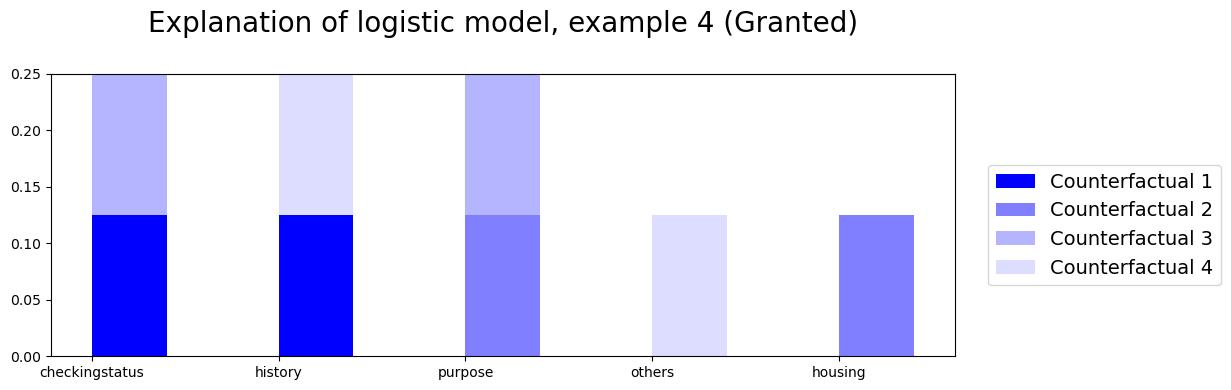

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,24,existing credits paid back duly till now,radio/television,1533,... < 100 DM,... < 1 year,4,female : divorced/separated/married,others - none,3,"car or other, not in attribute 6",> 25 years,stores,own,1,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,history,purpose,others,housing
Original,no checking account,existing credits paid back duly till now,radio/television,others - none,own
Counterfactual 1,... >= 200 DM / salary assignments for at leas...,all credits at this bank paid back duly,radio/television,others - none,own
Counterfactual 2,no checking account,existing credits paid back duly till now,education,others - none,rent
Counterfactual 3,... >= 200 DM / salary assignments for at leas...,existing credits paid back duly till now,car (new),others - none,own
Counterfactual 4,no checking account,all credits at this bank paid back duly,radio/television,co-applicant,own


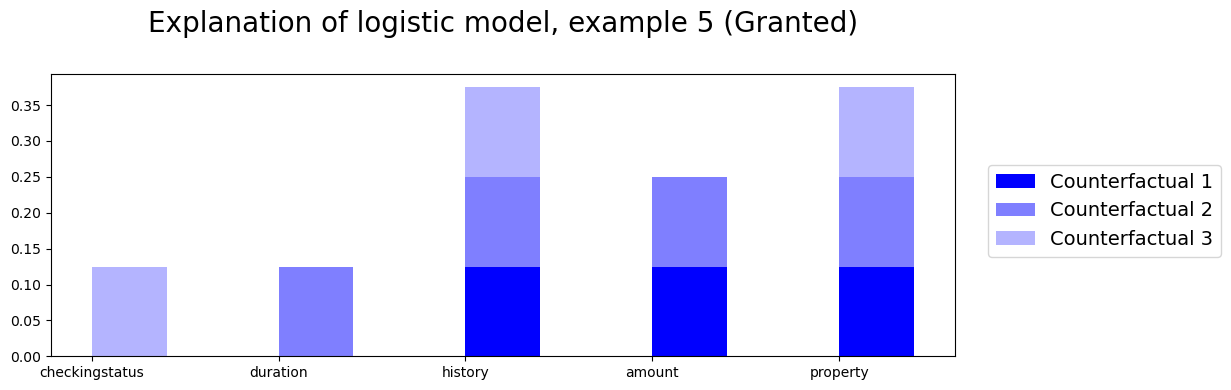

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,12,existing credits paid back duly till now,car (new),1101,... < 100 DM,1 <= ... < 4 years,3,male : married/widowed,others - none,2,real estate,> 25 years,none,own,2,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,duration,history,amount,property
Original,no checking account,12,existing credits paid back duly till now,1101,real estate
Counterfactual 1,no checking account,12,all credits at this bank paid back duly,1284,unknown / no property
Counterfactual 2,no checking account,13,all credits at this bank paid back duly,1134,unknown / no property
Counterfactual 3,... >= 200 DM / salary assignments for at leas...,12,all credits at this bank paid back duly,1101,unknown / no property


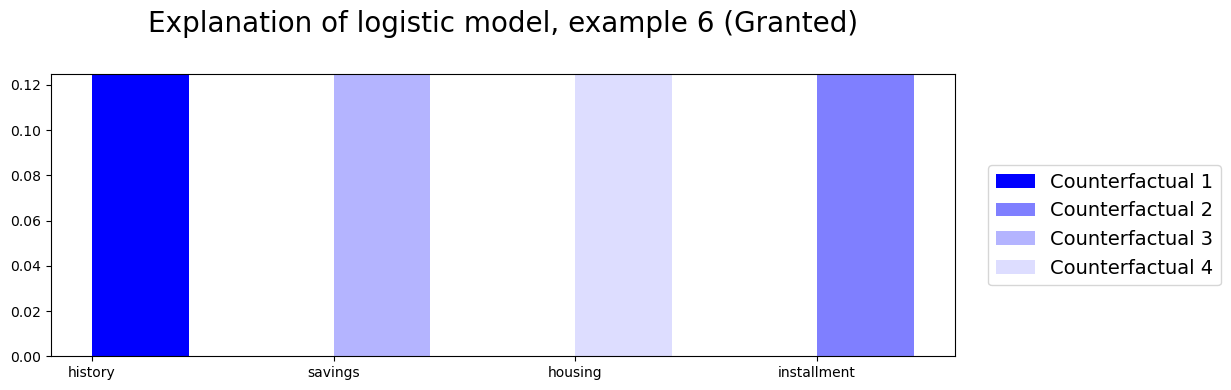

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,60,critical account/ other credits existing (not at this bank),car (new),13756,unknown/ no savings account,.. >= 7 years,2,male : single,others - none,4,unknown / no property,> 25 years,bank,for free,1,management/ self-employed/highly qualified employee/ officer,1,"phone - yes, registered under the customers name",foreign - yes


,history,savings,housing,installment
Original,critical account/ other credits existing (not ...,unknown/ no savings account,for free,2
Counterfactual 1,all credits at this bank paid back duly,unknown/ no savings account,for free,2
Counterfactual 2,critical account/ other credits existing (not ...,unknown/ no savings account,for free,4
Counterfactual 3,critical account/ other credits existing (not ...,... < 100 DM,for free,2
Counterfactual 4,critical account/ other credits existing (not ...,unknown/ no savings account,rent,2


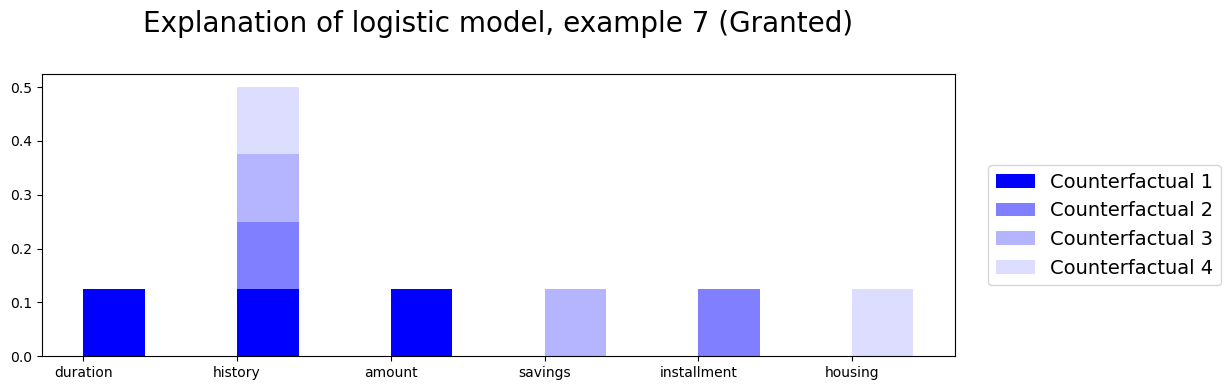

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... < 0 DM,6,critical account/ other credits existing (not at this bank),car (new),4716,unknown/ no savings account,... < 1 year,1,male : single,others - none,3,real estate,> 25 years,none,own,2,unskilled - resident,2,phone - none,foreign - yes


,duration,history,amount,savings,installment,housing
Original,6,critical account/ other credits existing (not ...,4716,unknown/ no savings account,1,own
Counterfactual 1,7,all credits at this bank paid back duly,5210,unknown/ no savings account,1,own
Counterfactual 2,6,all credits at this bank paid back duly,4716,unknown/ no savings account,4,own
Counterfactual 3,6,existing credits paid back duly till now,4716,... < 100 DM,1,own
Counterfactual 4,6,all credits at this bank paid back duly,4716,unknown/ no savings account,1,rent


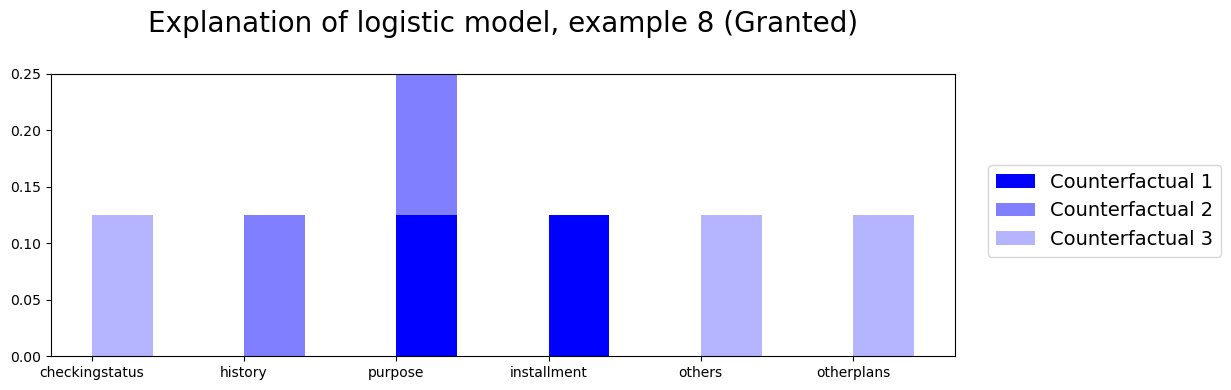

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
... >= 200 DM / salary assignments for at least 1 year,12,existing credits paid back duly till now,radio/television,1881,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,others - none,2,"car or other, not in attribute 6",> 25 years,none,rent,1,unskilled - resident,1,"phone - yes, registered under the customers name",foreign - yes


,checkingstatus,history,purpose,installment,others,otherplans
Original,... >= 200 DM / salary assignments for at leas...,existing credits paid back duly till now,radio/television,2,others - none,none
Counterfactual 1,... >= 200 DM / salary assignments for at leas...,existing credits paid back duly till now,car (new),4,others - none,none
Counterfactual 2,... >= 200 DM / salary assignments for at leas...,all credits at this bank paid back duly,car (new),2,others - none,none
Counterfactual 3,0 <= ... < 200 DM,existing credits paid back duly till now,radio/television,2,co-applicant,bank


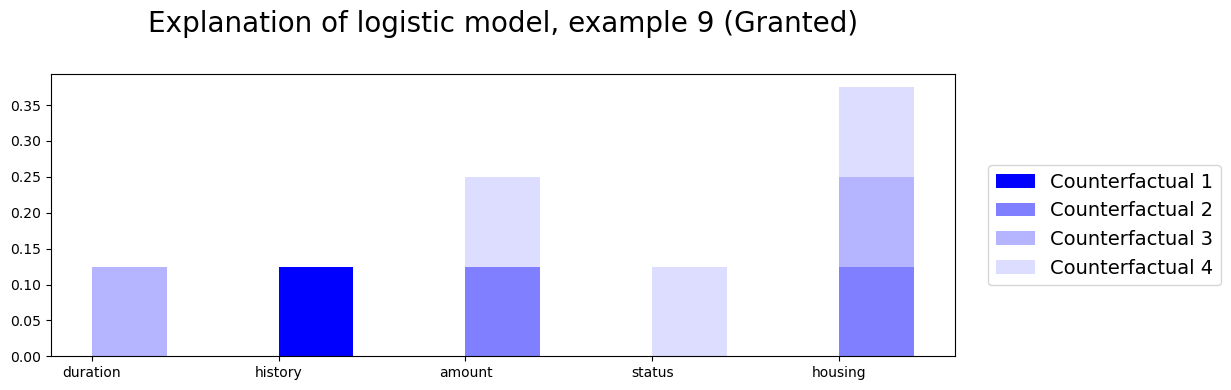

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,24,delay in paying off in the past,car (new),2032,... < 100 DM,.. >= 7 years,4,male : single,others - none,4,unknown / no property,> 25 years,none,for free,2,skilled employee / official,1,"phone - yes, registered under the customers name",foreign - yes


,duration,history,amount,status,housing
Original,24,delay in paying off in the past,2032,male : single,for free
Counterfactual 1,24,all credits at this bank paid back duly,2032,male : single,for free
Counterfactual 2,24,delay in paying off in the past,2157,male : single,rent
Counterfactual 3,25,delay in paying off in the past,2032,male : single,rent
Counterfactual 4,24,delay in paying off in the past,2079,male : married/widowed,rent


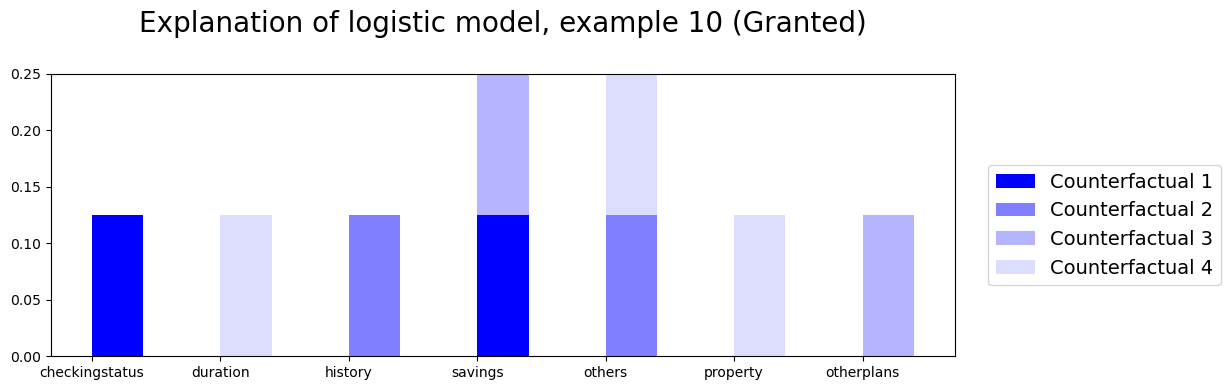

checkingstatus,duration,history,purpose,amount,savings,employ,installment,status,others,residence,property,age,otherplans,housing,cards,job,liable,telephone,foreign
no checking account,36,existing credits paid back duly till now,car (new),3079,unknown/ no savings account,1 <= ... < 4 years,4,male : single,others - none,4,real estate,> 25 years,none,own,1,skilled employee / official,1,phone - none,foreign - yes


,checkingstatus,duration,history,savings,others,property,otherplans
Original,no checking account,36,existing credits paid back duly till now,unknown/ no savings account,others - none,real estate,none
Counterfactual 1,... >= 200 DM / salary assignments for at leas...,36,existing credits paid back duly till now,... < 100 DM,others - none,real estate,none
Counterfactual 2,no checking account,36,all credits at this bank paid back duly,unknown/ no savings account,co-applicant,real estate,none
Counterfactual 3,no checking account,36,existing credits paid back duly till now,... < 100 DM,others - none,real estate,bank
Counterfactual 4,no checking account,37,existing credits paid back duly till now,unknown/ no savings account,co-applicant,unknown / no property,none


In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display, HTML
from typing import List
import math

# Method to display a table of the field values being explained and a histogram of the SHAP feature weights
# for a given example (displaying contributors towards the favorable outcome in green and those towards
# the unfavorable in red)
def display_explanations(example: List[ExplainedPrediction],
                         title: str,
                         is_favorable: bool):
    np_field_names = np.array(example[0].field_names)
    example_as_pandas = pd.DataFrame(np.expand_dims(example[0].instance, axis=0),
                                     columns=np_field_names)
    
    colors = np.array(['red', 'green'] if is_favorable else ['green', 'red'])
    fig, ax = plt.subplots(figsize=[12,4])
    ax.set_title(title, fontsize=20, pad=30)
    impactful_features = []
    all_cf_impactful_features = []
    shap_ex = None
    cf_changes = []
    cf_idx = 0
    shap_scale = 1.  # default for case with no SHAP
    for ex in example:
        if ex.explanation_type == ExplanationType.SHAP:
            shap_ex = ex
            shap_impactful_features = np.where(ex.explanation.feature_weights != 0.)[0]
            impactful_features.extend(shap_impactful_features.tolist())
            shap_scale = np.sum(np.abs(ex.explanation.feature_weights[shap_impactful_features])).item()
        else:
            cf_impactful_features = np.where(ex.explanation.best_individuals[0].data != ex.instance)[0]
            impactful_features.extend(cf_impactful_features.tolist())
            all_cf_impactful_features.extend(cf_impactful_features)
            cf_changes.append(pd.DataFrame(np.expand_dims(ex.explanation.best_individuals[0].data[cf_impactful_features], axis=0),
                                      columns=np_field_names[cf_impactful_features],
                                      index=[f'Counterfactual {cf_idx+1}']))
            cf_idx += 1
    impactful_features = np.array(list(set(impactful_features)))
    all_cf_impactful_features = np.array(list(set(all_cf_impactful_features)))

    if len(cf_changes) > 0:
        cf_changes.insert(0,
                          pd.DataFrame(np.expand_dims(ex.instance[all_cf_impactful_features], axis=0),
                              columns=np_field_names[all_cf_impactful_features],
                              index=['Original']))
        
    cf_idx = 0
    bottoms = np.zeros(impactful_features.shape[0])
    for ex in example:
        if ex.explanation_type == ExplanationType.SHAP:
            favorability_aligned_weights = ex.explanation.feature_weights[impactful_features]
            if not is_favorable:
                favorability_aligned_weights = -favorability_aligned_weights
            favorability = np.where(favorability_aligned_weights > 0)[0]
            favorable = np.arange(len(impactful_features))[favorability]
            unfavorability = np.where(favorability_aligned_weights < 0)[0]
            unfavorable = np.arange(len(impactful_features))[unfavorability]
            if len(favorable) > 0:
                ax.bar(favorable,
                       np.abs(ex.explanation.feature_weights[impactful_features][favorable]),
                       width=0.4,
                       color='green',
                       label="SHAP (favorable)")           
            if len(unfavorable) > 0:
                ax.bar(unfavorable,
                       np.abs(ex.explanation.feature_weights[impactful_features][unfavorable]),
                       width=0.4,
                       color='red',
                       label="SHAP (unfavorable)")
        else:
            color = (0,0,1,1-math.sqrt(cf_idx)/2)
            ax.bar(np.arange(len(impactful_features)) + 0.4,
                   (ex.explanation.best_individuals[0].data != ex.instance).astype('int')[impactful_features]*shap_scale/8,
                   width=0.4,
                   color=color,
                   label=f'Counterfactual {cf_idx+1}',
                   bottom=bottoms)
            bottoms[np.where((ex.explanation.best_individuals[0].data != ex.instance)[impactful_features])] += shap_scale/8
            cf_idx += 1
        ax.set_xticks(np.arange(len(impactful_features)) + 0.2)
        ax.set_xticklabels(np_field_names[impactful_features])
        
    fig.legend(fontsize=14, bbox_to_anchor=(1.03,.6))
    fig.tight_layout()
    fig.subplots_adjust(right=0.8)
    
    plt.show()
    
    if shap_ex is not None:
        display_force_plot(shap_ex, is_favorable)
    
    display(HTML(example_as_pandas.to_html(index=False)))
    
    if len(cf_changes) > 0:
        raw_changes = pd.concat(cf_changes, axis=0, sort=True)[np_field_names[all_cf_impactful_features].tolist()]
        display(raw_changes.fillna(raw_changes.iloc[0]))

max_displayed_examples = 10  # Just display the first few here for illustration

# from IPython.display import display, HTML
# display(HTML("<style>div.output_scroll { height: 48em; }</style>"))

all_explanations = explanations(result, include_alternates=True)
all_joint_explanations = {}
for model, examples in all_explanations.items():
    # Join the explanations on their instance data
    joint = {}
    for exp in list(examples):
        key = tuple(exp.instance.tolist()) # tuples are hashable
        joint[key] = joint.get(key, []) + [exp]
        
    all_joint_explanations[model] = []
    for idx, joint_exp in enumerate(list(joint.values())[:max_displayed_examples]):
        all_joint_explanations[model].append(joint_exp)
        granted = joint_exp[0].prediction == 1
        display_explanations(joint_exp,
                             f"Explanation of {model} model, example {idx+1} ({'Granted' if granted else 'Denied'})",
                             is_favorable=granted)

In [10]:
def score_tree(s, d=0):
    desc = f"{' '.join(['']*d)}{s.name}"
    print(desc)
    for c in s.children:
        score_tree(c, d+1)

all_scores = list(scores('fairness', result))
score_tree(all_scores[0])

fairness
status
 female
 male
